In [4]:
# ============================================================
# CONFIGURACIÓN GLOBAL (Reproducibilidad y modo rápido)
# ============================================================
# Semilla para que el split y los resultados sean repetibles
RANDOM_SEED = 42

# Tamaño del set de prueba
TEST_SIZE = 0.2

# Definición de "Best Seller" como TOP 25% en quantity_sold (percentil 75)
THRESH_Q = 0.75

# Submuestra por clase (0 y 1). Esto hace el notebook rápido en cualquier laptop.
# (Si tu PC aguanta más, sube a 2000 o 3000)
N_POR_CLASE = 1000

# Iteraciones ADVI (inferencia variacional) y cantidad de muestras del "trace"
# Mantener bajo para demo rápida; subir si tienes compilador y más tiempo.
ADVI_ITERS = 1000
TRACE_SAMPLES = 1000

# 1 — Contexto y objetivo

## Modelo 2 — Clasificador de Éxito (Regresión Logística Bayesiana)

**Objetivo:** estimar la probabilidad de que un producto sea un *Best Seller* (venta alta) usando como predictores `rating` y `discounted_price`.

### ¿Qué es “Best Seller”?

Lo definimos como estar en el **top 25% de `quantity_sold`**.  
Esto convierte el problema en una **clasificación binaria**:

- **1 = Best Seller**  
- **0 = No Best Seller**

### ¿Por qué un modelo Bayesiano?

Porque no solo queremos una predicción puntual (0/1), sino también **incertidumbre**:  
una **distribución posterior de probabilidades** y un **intervalo creíble**.

### Nota de ingeniería

El muestreo MCMC completo puede ser lento en notebooks (especialmente sin compilación C++).  
Para mantener el flujo rápido y reproducible, utilizamos:

- **Submuestra estratificada** (balanceada por clase)  
- **ADVI (Variational Inference)** para aproximar la posterior de forma eficiente  

In [7]:
import polars as pl
import numpy as np

# ============================================================
# 1) CARGA Y LIMPIEZA DE DATOS
# ============================================================
# Leemos el CSV con Polars (más eficiente que pandas para ETL)
df = pl.read_csv("../dataset/amazon_sales_dataset.csv")

# Seleccionamos SOLO columnas necesarias para el Modelo 2:
# - rating: predictor
# - discounted_price: predictor
# - quantity_sold: lo usamos para construir el target "best_seller"
df2 = (
    df.select(["rating", "discounted_price", "quantity_sold"])
      .drop_nulls()
      .filter(pl.col("rating").is_between(0, 5))     # ratings válidos
      .filter(pl.col("discounted_price") > 0)        # precios válidos
      .filter(pl.col("quantity_sold") >= 0)          # ventas válidas
)

print("Filas después de limpieza:", df2.height)
df2.head()

Filas después de limpieza: 50000


rating,discounted_price,quantity_sold
f64,f64,i64
3.5,115.88,4
3.7,242.08,5
4.4,396.64,2
5.0,316.16,4
4.6,201.68,4


### Definición del target: `best_seller`

Convertimos el problema en una **clasificación binaria**.

Definimos **Best Seller = top 25% de `quantity_sold` (percentil 75)**.

Esta elección:

- evita que el target sea “demasiado fácil”,  
- y se alinea mejor con el concepto real de **alto desempeño** dentro del catálogo.

En resumen:

- **1 = Best Seller**  
- **0 = No Best Seller**

In [8]:
# ============================================================
# 2) TARGET: BEST SELLER (TOP 25% EN quantity_sold)
# ============================================================
# Calculamos el umbral (percentil 75). Todo lo que esté por encima será Best Seller = 1
threshold = df2.select(pl.col("quantity_sold").quantile(THRESH_Q)).item()

# Creamos la columna binaria
df2 = df2.with_columns(
    (pl.col("quantity_sold") >= threshold).cast(pl.Int8).alias("best_seller")
)

print("Umbral quantity_sold (p75):", threshold)

# Balance de clases: cuántos 0 y cuántos 1
df2.group_by("best_seller").len().sort("best_seller")

Umbral quantity_sold (p75): 4.0


best_seller,len
i8,u32
0,30000
1,20000


## Submuestra estratificada (aceleración)

Los métodos bayesianos (MCMC o VI) pueden ser costosos cuando el dataset contiene muchas filas.  
Para que el notebook sea **rápido y reproducible**, utilizamos una **muestra estratificada y balanceada por clase** (mismo número de 0 y 1).

Esto permite:

- Mantener la señal del problema  
- Reducir significativamente el tiempo computacional  
- Acelerar el entrenamiento tanto con MCMC como con ADVI

In [9]:
# ============================================================
# 3) SUBMUESTRA ESTRATIFICADA (balanceada por clase)
# ============================================================
# Tomamos N_POR_CLASE por cada valor del target: 0 y 1.
# Esto reduce el tamaño de datos para que ADVI/NUTS corran rápido.
df_small = (
    df2.group_by("best_seller")
       .map_groups(lambda g: g.sample(n=min(N_POR_CLASE, g.height), seed=RANDOM_SEED))
)

print("Filas df_small:", df_small.height)
df_small.group_by("best_seller").len().sort("best_seller")

Filas df_small: 2000


best_seller,len
i8,u32
0,1000
1,1000


## Features / split / escalado

### Preparación de datos para el modelo

Para preparar los datos antes del modelado bayesiano realizamos los siguientes pasos:

- Convertimos **Polars → NumPy**, ya que tanto *scikit-learn* como *PyMC* trabajan de forma más natural con arrays NumPy.
- Aplicamos un **split estratificado** para mantener la proporción de clases en los conjuntos de entrenamiento y prueba.
- Escalamos las variables numéricas para mejorar la **estabilidad numérica**, algo especialmente importante en inferencia bayesiana donde la escala de los predictores puede afectar la convergencia.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ============================================================
# 4) FEATURES (X) y TARGET (y)
# ============================================================
# X: variables predictoras
# y: etiqueta binaria
X = df_small.select(["rating", "discounted_price"]).to_numpy()
y = df_small.select("best_seller").to_numpy().ravel()

# Split estratificado: conserva proporciones de clases en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y
)

# Escalado: centra y normaliza, evita problemas numéricos y acelera optimización/inferencia
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Validaciones visibles (señal profesional en notebooks)
print("Shapes:")
print("Train:", X_train_s.shape, y_train.shape)
print("Test :", X_test_s.shape, y_test.shape)

print("\nBalance Train:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Balance Test :", dict(zip(*np.unique(y_test, return_counts=True))))

Shapes:
Train: (1600, 2) (1600,)
Test : (400, 2) (400,)

Balance Train: {np.int8(0): np.int64(800), np.int8(1): np.int64(800)}
Balance Test : {np.int8(0): np.int64(200), np.int8(1): np.int64(200)}


## Modelo: Regresión Logística Bayesiana

Usamos **regresión logística** porque su salida natural es una **probabilidad entre 0 y 1**, lo que encaja perfectamente con el objetivo del modelo.

### ¿Por qué Bayesiano?

En un enfoque bayesiano:

- Los coeficientes (`beta_0`, `beta_rating`, `beta_price`) **no son números fijos**.  
- Cada uno es una **distribución posterior** que refleja la incertidumbre del modelo.

Esto permite:

- Cuantificar la **incertidumbre** en cada parámetro  
- Obtener distribuciones completas en lugar de estimaciones puntuales  
- Construir **intervalos creíbles**, fundamentales para interpretar la confianza del modelo

In [11]:
import pymc as pm
import arviz as az

# ============================================================
# 5) REGRESIÓN LOGÍSTICA BAYESIANA (ADVI rápido)
# ============================================================
# logit(p) = beta_0 + beta_rating * rating + beta_price * discounted_price
# p = sigmoid(logit)
# y ~ Bernoulli(p)
with pm.Model() as model:
    # Priors: centrados en 0, sigma moderada porque X está estandarizado
    beta_0 = pm.Normal("beta_0", 0, 2)
    beta_rating = pm.Normal("beta_rating", 0, 2)
    beta_price = pm.Normal("beta_price", 0, 2)

    # Predictor lineal (log-odds)
    logit_p = beta_0 + beta_rating * X_train_s[:, 0] + beta_price * X_train_s[:, 1]

    # Transformación a probabilidad (0 a 1)
    p = pm.Deterministic("p", pm.math.sigmoid(logit_p))

    # Likelihood: datos binarios
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y_train)

    # ADVI: aproximación rápida de la posterior (ideal para notebooks)
    approx = pm.fit(n=ADVI_ITERS, method="advi", random_seed=RANDOM_SEED)

    # Tomamos muestras de la posterior aproximada
    trace = approx.sample(TRACE_SAMPLES, random_seed=RANDOM_SEED)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
c:\Users\torre\OneDrive\Escritorio\5_Regresion_bayesiana\5_Regresion_bayesiana\.venv\Lib\site-packages\arviz\__init__.py:50: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


Output()

Finished [100%]: Average Loss = 1,323.7


## Interpretación de coeficientes

### Interpretación (qué significa cada beta)

- **beta_rating > 0**  
  A mayor *rating*, mayor probabilidad de que un producto sea *Best Seller*.

- **beta_price < 0**  
  A mayor precio, menor probabilidad de ser *Best Seller* (si el modelo aprende ese efecto).

- **beta_0 (intercepto)**  
  Representa la probabilidad base cuando las variables están en **0 estandarizado** (es decir, en su media después del escalado).

In [12]:
az.summary(trace, var_names=["beta_0", "beta_rating", "beta_price"])

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,-0.017,0.590,-1.031,1.180,0.019,0.015,1008.0,897.0,NaN
beta_rating,0.044,0.596,-1.132,1.129,0.018,0.013,1085.0,985.0,NaN
beta_price,0.030,0.590,-1.044,1.145,0.019,0.013,1005.0,819.0,NaN


## Predicción Bayesiana con incertidumbre

En lugar de generar una sola probabilidad puntual, utilizamos las **muestras de la distribución posterior** para obtener muchas probabilidades por observación.

A partir de estas muestras podemos calcular:

- **Probabilidad media (`p_mean`)**
- **Intervalo creíble (`p_low`, `p_high`)**

Esto permite medir **qué tan seguro está el modelo** en cada predicción, en lugar de depender únicamente de un valor único.

In [13]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# Extraemos muestras posteriores
b0 = trace.posterior["beta_0"].values.reshape(-1)
b1 = trace.posterior["beta_rating"].values.reshape(-1)
b2 = trace.posterior["beta_price"].values.reshape(-1)

# Probabilidad por muestra posterior y por dato
logits = b0[:, None] + b1[:, None]*X_test_s[:, 0][None, :] + b2[:, None]*X_test_s[:, 1][None, :]
p_samples = 1/(1+np.exp(-logits))

# Resumen por observación
p_mean = p_samples.mean(axis=0)
p_low = np.quantile(p_samples, 0.05, axis=0)
p_high = np.quantile(p_samples, 0.95, axis=0)

# Clasificación con umbral 0.5
y_pred = (p_mean >= 0.5).astype(int)

# Métricas de clasificación
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, p_mean)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"AUC:      {auc:.4f}")
print("Confusion matrix:\n", cm)

Accuracy: 0.4900
AUC:      0.4698
Confusion matrix:
 [[115  85]
 [119  81]]


## Curva de probabilidad (entregable)

### Curva de probabilidad con incertidumbre

Mostramos cómo cambia **P(Best Seller)** cuando aumenta el *rating*, manteniendo el precio fijo (por ejemplo, en su mediana).

La banda sombreada corresponde al **intervalo creíble (5%–95%)** y representa la **incertidumbre** del modelo alrededor de la probabilidad estimada.

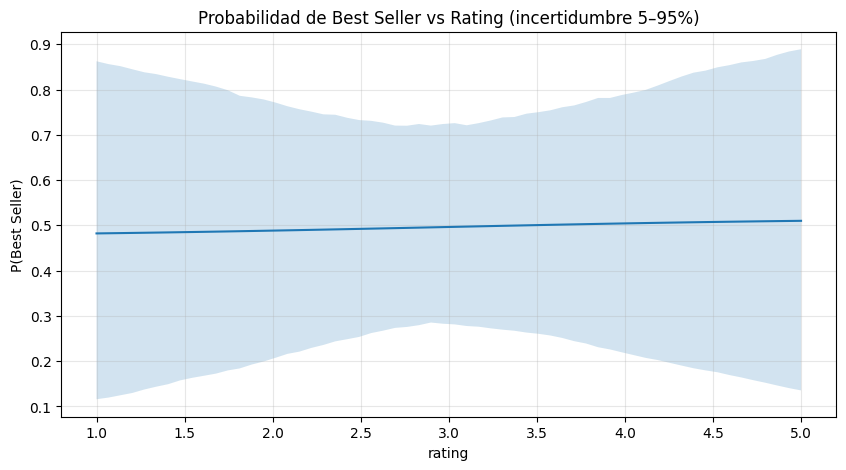

In [14]:
import matplotlib.pyplot as plt

rating_grid = np.linspace(X[:, 0].min(), X[:, 0].max(), 60)
price_fixed = np.median(X[:, 1])

grid_raw = np.column_stack([rating_grid, np.full_like(rating_grid, price_fixed)])
grid_s = scaler.transform(grid_raw)

logits_grid = b0[:, None] + b1[:, None]*grid_s[:, 0][None, :] + b2[:, None]*grid_s[:, 1][None, :]
p_grid = 1/(1+np.exp(-logits_grid))

p_grid_mean = p_grid.mean(axis=0)
p_grid_low = np.quantile(p_grid, 0.05, axis=0)
p_grid_high = np.quantile(p_grid, 0.95, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(rating_grid, p_grid_mean)
plt.fill_between(rating_grid, p_grid_low, p_grid_high, alpha=0.2)
plt.xlabel("rating")
plt.ylabel("P(Best Seller)")
plt.title("Probabilidad de Best Seller vs Rating (incertidumbre 5–95%)")
plt.grid(alpha=0.3)
plt.show()

In [15]:
import os, joblib

# Guardamos artefactos para reproducir predicciones en otro entorno (Streamlit/API)
os.makedirs("models", exist_ok=True)

joblib.dump(scaler, "models/modelo2_scaler.joblib")
az.to_netcdf(trace, "models/modelo2_trace.nc")

print("✅ Export listo: models/modelo2_scaler.joblib + models/modelo2_trace.nc")

✅ Export listo: models/modelo2_scaler.joblib + models/modelo2_trace.nc
